In [34]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [35]:
import os

cwd = os.getcwd()
cwd
benchmark_result_path = os.path.realpath(
    os.path.join(cwd, "../data/benchmark-results.csv")
)
benchmark_result_path

'/Users/csalih/Developer/bsc-web-benchmark/benchmark/benchmark-analyze/data/benchmark-results.csv'

In [58]:
# Load the dataset
csv_headers = ["framework", "metric", "os", "browser", "value"]
df = pd.read_csv(benchmark_result_path, names=csv_headers)

# Group the data
frameworks = df["framework"].unique()
metrics = df["metric"].unique()
browsers = df["browser"].unique()
operating_systems = df["os"].unique()

df_by_metric = df.groupby('metric')

# Display basic info
print(df.head())

     framework                          metric      os   browser  value
0  app-angular            create_1000_duration  darwin  chromium   61.2
1  app-angular           create_10000_duration  darwin  chromium  578.6
2  app-angular       append_1000_rows_duration  darwin  chromium   58.7
3  app-angular  update_every_10th_row_duration  darwin  chromium    6.5
4  app-angular              swap_rows_duration  darwin  chromium    6.4


In [ ]:
# Validate

# Check if there is sufficient data for ANOVA
if df["framework"].nunique() < 0 or df["browser"].nunique() < 0:
    raise Exception(f"Metric {metric} has insufficient data.")


# Group by all factors and count the number of observations
counts = df.groupby(['framework', 'metric', 'browser']).size().reset_index(name='count')
single_observations = counts[counts['count'] == 1]

if not single_observations.empty:
    print("WARNING: The following groups have only one observation. ANOVA may fail:")
    print(single_observations)
    raise Exception("Consider combining levels or simplifying your model.")

In [59]:
# Initialize a results dictionary
anova_results = {}

for metric, group_df in df_by_metric:
    # Perform ANOVA for the metric
    model = ols('value ~ C(framework) + C(browser)', data=group_df).fit()
    anova_results[metric] = sm.stats.anova_lm(model, typ=2)

    print(f"ANOVA Results for Metric: {metric}")
    print(anova_results[metric])
    print("")

ANOVA Results for Metric: append_1000_rows_duration
                   sum_sq     df           F        PR(>F)
C(framework)  3274.466000    3.0   78.883787  1.084710e-27
C(browser)    7267.572667    2.0  262.620068  2.092794e-43
Residual      1577.379999  114.0         NaN           NaN

ANOVA Results for Metric: create_10000_duration
                    sum_sq     df           F        PR(>F)
C(framework)  4.160677e+05    3.0   85.414685  4.951393e-29
C(browser)    3.169575e+06    2.0  976.024711  1.907903e-72
Residual      1.851037e+05  114.0         NaN           NaN

ANOVA Results for Metric: create_1000_duration
                   sum_sq     df           F        PR(>F)
C(framework)  1820.790000    3.0   60.860955  1.450309e-23
C(browser)    3924.170667    2.0  196.751498  1.080378e-37
Residual      1136.854000  114.0         NaN           NaN

ANOVA Results for Metric: swap_rows_duration
                    sum_sq     df           F        PR(>F)
C(framework)  39458.364916    3.0

     Multiple Comparison of Means - Tukey HSD, FWER=0.50      
   group1     group2   meandiff p-adj   lower    upper  reject
--------------------------------------------------------------
app-angular app-leptos   17.144 0.9294 -22.2895 56.5775  False
app-angular  app-react  28.2213 0.7484 -11.2122 67.6549  False
app-angular    app-vue  -11.188 0.9788 -50.6215 28.2455  False
 app-leptos  app-react  11.0773 0.9794 -28.3562 50.5109  False
 app-leptos    app-vue  -28.332 0.7462 -67.7655 11.1015  False
  app-react    app-vue -39.4093 0.5005 -78.8429  0.0242  False
--------------------------------------------------------------
   Multiple Comparison of Means - Tukey HSD, FWER=0.50   
 group1   group2 meandiff p-adj   lower    upper   reject
---------------------------------------------------------
chromium firefox  -33.226 0.3547 -60.3725  -6.0795   True
chromium  webkit   52.984 0.0732  25.8375  80.1305   True
 firefox  webkit    86.21 0.0011  59.0635 113.3565   True
----------------------

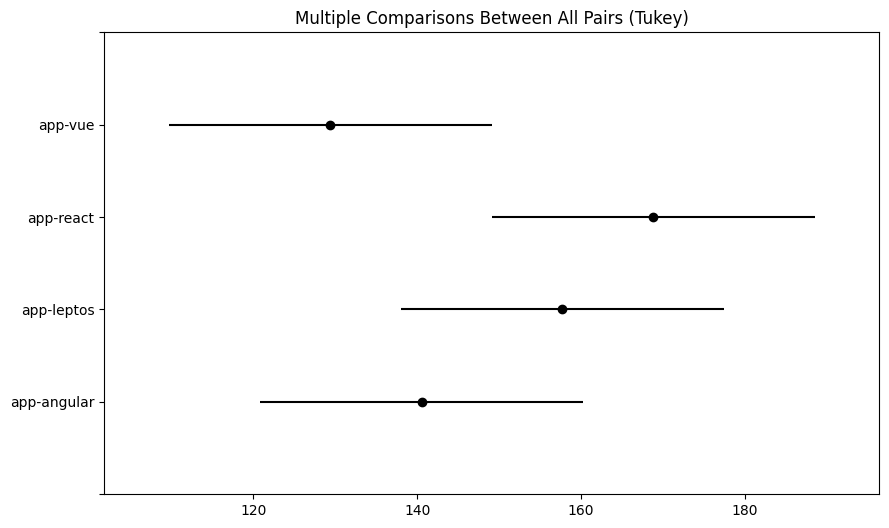

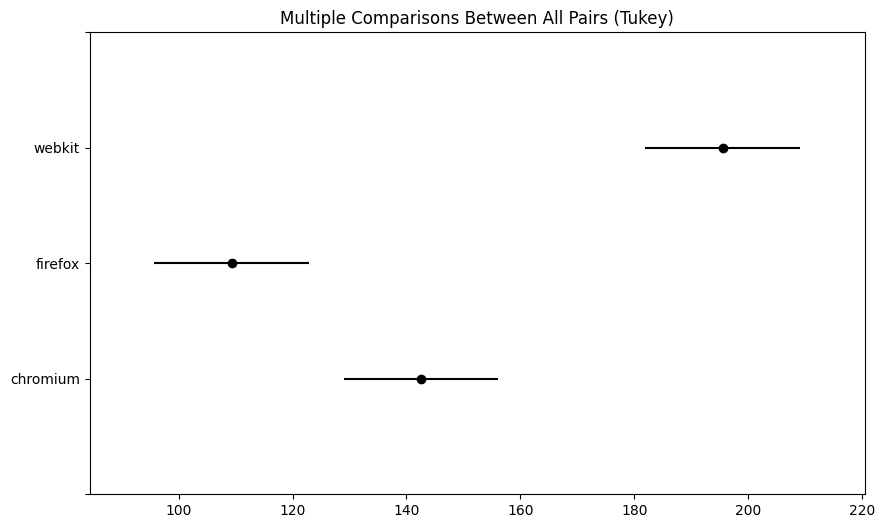

In [64]:
alpha = 0.5
factors = ['framework', 'browser'] # TODO: add os

# Lets see one metric only
metric = metrics[0]
anova_table = anova_results[metric]

for factor in factors:
    tukey = pairwise_tukeyhsd(endog=df['value'],     # Data
                              groups=df[factor],     # Groups
                              alpha=alpha)           # Significance level

    print(tukey.summary())

    # Plot group confidence intervals
    tukey.plot_simultaneous()
    plt.vlines(x=49.57, ymin=-0.5, ymax=4.5, color="red")